# ISE 633 Homework 2 (coding part)

Author: Yue Wu <wu.yue@usc.edu>
$\def\vf#1{\boldsymbol{#1}}$

This notebook is the coding part of the second homework of ISE 633. It is written in a style where code and explanations are interleaved. The notebook is written in Python 3.12 and is best viewed in a Jupyter notebook environment.

### Dependencies

It requires the following packages:

```plain
jax==0.4.23
jaxtyping==0.2.25
beartype==0.17.2
equinox==0.11.3
```

and reasonably new versions of `seaborn`, `matplotlib` and `pandas`. The notebook is exclusively written in Python 3.12+. Since the computation is done with JAX with its fully deterministic RNGs, the results should be completely reproducible.

In [1]:
### IMPORT
from functools import partial

import beartype
import equinox as eqx
import ipytest
import jax
import jax.scipy.optimize
import jaxtyping
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from beartype.typing import Any, Callable, cast
from jax import numpy as jnp, random as jr, tree_util as jtu
from jaxtyping import Array, Bool, Float, Integer, Key, Scalar, jaxtyped
from matplotlib.axes import Axes

import utils.platform
from utils.hash import my_hash
from utils.tree import tree_stack, tree_unstack

ipytest.autoconfig()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_threefry_partitionable", True)

utils.platform.init_matplotlib("svg")
sns.set_theme("notebook", style="whitegrid")

SingleKey = Key[Scalar, ""]
typechecked = jaxtyped(typechecker=beartype.beartype)
FloatLike = float | Float[Scalar, ""]


def jconst(x) -> Float[Scalar, ""]:
    return jnp.array(x, dtype=float)

## Problem 1

On different descent methods on a quadratic optimization problem.

Generate the matrix $\vf Q$ and the vector $\vf b$ according to the procedure described in the problem.


In [2]:
class QuadraticOptimization(eqx.Module):
    Q: Float[Array, "n n"]
    b: Float[Array, " n"]

    @typechecked
    def __call__(self, x: Float[Array, " n"]) -> Float[Scalar, ""]:
        return 0.5 * x.T @ self.Q @ x + jnp.dot(self.b, x)


@typechecked
def generate_qd(
    n: int, diag_noise_scale: FloatLike, offset: FloatLike, key: SingleKey
) -> QuadraticOptimization:
    B_key, D_key, b_key = jr.split(key, 3)
    B = jr.normal(B_key, (n, n))
    D_diag = jnp.exp(jr.normal(D_key, (n,)) + offset)
    D = jnp.diag(D_diag)
    Q = B @ B.T + D
    b = jr.normal(b_key, (n,))
    return QuadraticOptimization(Q, b)


@typechecked
def condition_number(Q: Float[Array, "n n"]) -> Float[Scalar, ""]:
    return jnp.linalg.cond(Q)

In [3]:
p1_key = jr.key(20240215)
qd_p1_key, p1_key = jr.split(p1_key)
n = 100
qd_p1 = generate_qd(n, 1.0, 0.0, qd_p1_key)
lipschitz_p1 = jnp.max(jnp.linalg.eigvalsh(qd_p1.Q))
κ_p1 = condition_number(qd_p1.Q)
print(f"κ = {κ_p1:.2f}, L = {lipschitz_p1:.2f}")

κ = 309.96, L = 380.06


First order optimality condition for the quadratic optimization problem is:

$$
\nabla f(\vf x^*) = \vf Q \vf x^* + \vf b = 0 \\
\vf Q \vf x^* = -\vf b\\
\vf x^* = -\vf Q^{-1} \vf b
$$


In [4]:
@typechecked
def first_order_solve(qd: QuadraticOptimization) -> Float[Array, "n"]:
    return jnp.linalg.solve(qd.Q, -qd.b)


x_opt_p1 = first_order_solve(qd_p1)
assert jnp.allclose(jax.grad(qd_p1)(x_opt_p1), 0.0)

### Implementation of algorithms

Implement classical gradient descent algorithm with these step-size selection rules:

- Exact line search.
- Armijo rule.
- Diminishing step-size rule $α^r = {α\over r}$. Choose the best $α$ by try and error.
- Constant step-size rule $α^r = {1\over L}$ where $L$ is the Lipschitz constant of the gradient of the objective
  function.


In [5]:
@typechecked
def fixed_stepsize_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None = None,
    /,
    stepsize: Float[Scalar, ""] = jconst(0.1),
) -> Float[Array, " n"]:
    direc = -jax.grad(fun)(x)
    return x + stepsize * direc


@typechecked
def diminishing_stepsize_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None | Integer[Scalar, ""] = None,
    /,
    initial_stepsize: Float[Scalar, ""] = jconst(1),
) -> tuple[Float[Array, " n"], Integer[Scalar, ""]]:
    t = jnp.array(1, dtype=int) if extra is None else extra
    direc = -jax.grad(fun)(x)
    return (x + initial_stepsize / t * direc, t + 1)


@typechecked
def line_search_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None = None,
    /,
    direc: None | Float[Array, " n"] = None,
) -> Float[Array, " n"]:
    direc = -jax.grad(fun)(x) if direc is None else direc

    @jax.jit
    def inner(alpha: Float[Scalar, ""]) -> Float[Scalar, ""]:
        return fun(x + alpha * direc)

    alpha = jax.scipy.optimize.minimize(inner, jnp.array([0.0]), method="BFGS").x
    return x + alpha * direc


@typechecked
def armijo_rule_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None = None,
    /,
    max_stepsize: Float[Scalar, ""] = jconst(1),
    min_stepsize: Float[Scalar, ""] = jconst(1e-7),
    stepsize_shrink: Float[Scalar, ""] = jconst(0.5),
    descent_percentage: Float[Scalar, ""] = jconst(0.8),
    direc: None | Float[Array, " n"] = None,
) -> Float[Array, " n"]:
    if direc is None:
        fun_x, direc = jax.value_and_grad(fun)(x)
        direc = -cast(Float[Array, " n"], direc)
    else:
        fun_x = fun(x)

    @jax.jit
    def inner(alpha: Float[Scalar, ""]) -> Float[Scalar, ""]:
        return fun(x + alpha * direc) - fun_x

    descent_threshold = descent_percentage * jax.grad(inner)(0.0)
    alpha = jax.lax.while_loop(
        lambda alpha: jnp.logical_and(
            inner(alpha) > descent_threshold * alpha, alpha > min_stepsize
        ),
        lambda alpha: alpha * stepsize_shrink,
        max_stepsize,
    )
    return x + alpha * direc

- Implement accelerated gradient method discussed in the class.

In [6]:
@typechecked
def nestrov_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None
    | tuple[Float[Array, " n"], Integer[Scalar, ""], Float[Scalar, ""]] = None,
    /,
    stepsize: Float[Scalar, ""] = jconst(0.1),
    restart: Integer[Scalar, ""] = jnp.array(30, dtype=int),
) -> tuple[
    Float[Array, " n"],
    tuple[Float[Array, " n"], Integer[Scalar, ""], Float[Scalar, ""]],
]:
    extra = extra or (jnp.zeros_like(x), jnp.array(1, dtype=int), jconst(0.0))
    prev_x, r, a = extra
    next_a = (1 + jnp.sqrt(1 + 4 * a**2)) * 0.5
    next_t = (a - 1) / next_a
    next_y = (1 + next_t) * x - next_t * prev_x
    next_x = next_y - stepsize * jax.grad(fun)(next_y)
    next_extra = jax.lax.cond(
        r >= restart,
        lambda _: (next_x, jnp.array(1, dtype=int), jconst(0.0)),
        lambda _: (x, r + 1, next_a),
        None,
    )
    return next_x, next_extra

- Implement Newton method

In [7]:
@typechecked
def newton_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None = None,
):
    hess = jax.hessian(fun)(x)
    direc = jnp.linalg.solve(hess, -jax.grad(fun)(x))
    return x + direc

### Test section

Here we use some basic tests to ensure that the implementation is correct.

In [8]:
ipytest.clean()


@typechecked
def test_line_search_step():
    qd = QuadraticOptimization(
        jnp.array([[1.0, 0.0], [0.0, 1.0]]), jnp.array([0.0, 0.0])
    )
    x = jnp.array([1.0, 1.0])
    direc = jnp.array([-1.0, 0.0])
    step = line_search_step(x, qd, direc=direc)
    assert jnp.allclose(step, jnp.array([0.0, 1.0]))
    direc = jnp.array([0.0, -1.0])
    step = line_search_step(x, qd, direc=direc)
    assert jnp.allclose(step, jnp.array([1.0, 0.0]))


@typechecked
def test_armijo():
    @jax.jit
    @typechecked
    def fun(x: Float[Array, " n"]) -> Float[Scalar, ""]:
        return jnp.sum(0.5 * x**2)

    x = jnp.array([-1.0])
    direc = -jax.grad(fun)(x)
    step = armijo_rule_step(
        x,
        fun,
        direc=direc,
        max_stepsize=jconst(512),
        stepsize_shrink=jconst(0.5),
        descent_percentage=jconst(0.5),
    )
    assert jnp.allclose(step, jnp.array([0.0]))


@typechecked
def test_newton():
    @jax.jit
    @typechecked
    def fun(x: Float[Array, " n"]) -> Float[Scalar, ""]:
        return 0.5 * jnp.sum(x**2)

    x = jnp.array([-1.0, 2.0, -3.0])
    step = newton_step(x, fun)
    assert jnp.allclose(step, jnp.array([0.0]))


ipytest.run()

...                                                                                          [100%]
3 passed in 4.46s


<ExitCode.OK: 0>

### Main descent framework

In [9]:
Extra = Any | None
StepFunction = Callable[
    [Float[Array, " n"], Callable[[Float[Array, " n"]], Float[Scalar, ""]], Extra],
    Float[Array, " n"] | tuple[Float[Array, " n"], Extra],
]

Carry = tuple[Float[Array, " n"], Extra]
Output = tuple[Float[Array, " n"], Float[Scalar, ""]]


@partial(jax.jit, static_argnums=[2], static_argnames=["max_iter"])
@typechecked
def descent(
    x0: Float[Array, "n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    step: StepFunction,
    /,
    max_iter: int = 100,
    extra0: None = None,
) -> tuple[Float[Array, "m n"], Float[Scalar, " m"]]:
    @jax.jit
    @typechecked
    def iter(carry: Carry, input: None) -> tuple[Carry, Output]:
        x, extra = carry
        new = step(x, fun, extra)
        if isinstance(new, tuple):
            new_x, new_extra = new
        else:
            new_x, new_extra = new, extra
        return (new_x, new_extra), (x, fun(x))

    (x1, extra1), (x0, f0) = iter((x0, extra0), None)
    cn, os = jax.lax.scan(iter, (x1, extra1), None, length=max_iter - 1)
    xs, fs = os
    return jnp.concatenate([x0[None, :], xs]), jnp.concatenate([f0[None], fs])

In the following code cell we find the optimal step size for the diminishing step-size rule by trying different values of $\alpha$.

In [10]:
def find_step_size(func):
    @jax.jit
    def evaluate_step_size(alpha):
        return descent(
            jnp.zeros(n),
            func,
            partial(diminishing_stepsize_step, initial_stepsize=jconst(alpha)),
            max_iter=1000,
        )[1][-1]

    min = 1e-6
    pow = 10**0.1
    alpha = min
    best_eval = evaluate_step_size(alpha)
    best_alpha = alpha
    while True:
        alpha *= pow
        eval = evaluate_step_size(alpha)
        if eval < best_eval:
            best_eval = eval
            best_alpha = alpha
        elif eval > 1:
            break
    return best_alpha


diminishing_optimal_step_p1 = find_step_size(qd_p1)
diminishing_optimal_step_p1

0.15848931924611181

### Experiment for Problem 1

Running Diminishing step
Running Constant step
Running Line Search step
Running Armijo step
Running Nestrov step
Running Newton step


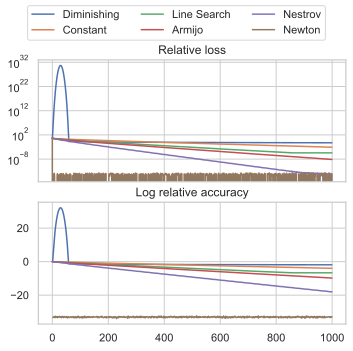

In [11]:
test_setups = [
    (
        "Diminishing",
        partial(
            diminishing_stepsize_step,
            initial_stepsize=jconst(diminishing_optimal_step_p1),
        ),
    ),
    ("Constant", partial(fixed_stepsize_step, stepsize=jconst(1 / lipschitz_p1))),
    ("Line Search", line_search_step),
    (
        "Armijo",
        partial(
            armijo_rule_step,
            max_stepsize=jconst(1),
            stepsize_shrink=jconst(0.5),
            descent_percentage=jconst(0.8),
        ),
    ),
    ("Nestrov", partial(nestrov_step, stepsize=jconst(1 / lipschitz_p1))),
    ("Newton", newton_step),
]


def log_relative_accuracy(x, x_opt, x0):
    return jnp.log(jnp.linalg.norm(x - x_opt) / jnp.linalg.norm(x0 - x_opt))


def run_plot(test_setups, func, x_opt, max_iter: int = 1000):
    plt.ioff()
    fig, axs = plt.subplots(2, 1, figsize=(4.8, 4.8), sharex=True, layout="constrained")
    axs = cast(list[Axes], list(axs.flatten()))
    ax1, ax2 = axs
    ax1.set_title("Relative loss")
    ax2.set_title("Log relative accuracy")

    for name, step in test_setups:
        print(f"Running {name} step")
        xs, fs = descent(jnp.zeros(n), func, step, max_iter=max_iter)
        ax1.plot(fs - func(x_opt), label=name)
        log_rel_acc = jax.vmap(log_relative_accuracy, (0, None, None))(
            xs, x_opt, jnp.zeros(n)
        )
        ax2.plot(log_rel_acc, label=name)

    ax1.set_yscale("log")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="outside upper center", ncol=3)
    plt.show()


run_plot(test_setups, qd_p1, x_opt_p1)

We then run the main experiment for problem 1, and show the average performance of the 6 algorithms.

The following code cell also prints the condition numbers of the $5$ matrices $\vf Q$ generated in the problem.

In [12]:
n_experiments = 5
experiment_master_key = jr.key(20240216)
experiment_keys = jr.split(experiment_master_key, n_experiments)
qds = jax.vmap(partial(generate_qd, n, 1.0, 0.0))(experiment_keys)
condition_numbers = jax.vmap(condition_number)(qds.Q)
print(f"Condition numbers: {jnp.round(condition_numbers, 2)}")


def run_experiment_p1(i, qd):
    x_opt = first_order_solve(qd)
    results = {}
    for name, step in test_setups:
        xs, fs = descent(jnp.zeros(n), qd, step, max_iter=1000)
        log_rel_acc = jax.vmap(log_relative_accuracy, (0, None, None))(
            xs, x_opt, jnp.zeros(n)
        )
        results[name] = {"rel_loss": fs[-1] - qd(x_opt), "log_rel_acc": log_rel_acc[-1]}
    return results


results = jax.vmap(run_experiment_p1, (0, 0))(jnp.arange(n_experiments), qds)
avg_results = jtu.tree_map(jnp.mean, results)

Condition numbers: [352.89 420.27 304.25 307.43 381.56]


The average performance of our algorithms is shown in the following table. The column `log_rel_acc` is the value asked by the assignment.

In [13]:
pd.DataFrame.from_dict(avg_results, orient="index")

,log_rel_acc,rel_loss
Armijo,-8.738920551431029,6.644689767298929e-08
Constant,-3.7921989945615886,0.0010506822982462084
Diminishing,-1.4982611867245572,1.4931939926205906
Line Search,-6.355262092969696,4.935995417820749e-06
Nestrov,-15.354339827749522,4.662936703425657e-13
Newton,-32.802627726541594,1.5987211554602255e-15


> Assume that the dimension $n$ is huge. Which algorithm would you use for computing $x^\star$? Newton, gradient descent, accelerated Nesterov, or closed-form solution? Justify your answer.

I would use Nestrov. Closed-form and Newton's method both requires calculating the inverse of some $n\times n$ matrix, which is $O(n^3)$ and computationally expensive. Nestrov converges faster than vanilla gradient descent, so it is the best choice. (Armijo and line search may call the primal function too many times, which is not efficient.)

## Problem 2
Repeat Problem 1 with a different distribution of $\vf Q$.

In [14]:
n_experiments = 5
experiment_master_key = jr.key(my_hash("problem 2"))
experiment_keys = jr.split(experiment_master_key, n_experiments)
qds = jax.vmap(partial(generate_qd, n, 0.01, 5.0))(experiment_keys)
condition_numbers = jax.vmap(condition_number)(qds.Q)
print(f"Condition numbers: {jnp.round(condition_numbers, 2)}")
lipschitz_p2 = jax.vmap(lambda q: jnp.max(jnp.linalg.eigvalsh(q)))(qds.Q)
bound_lipschitz_p2 = jnp.max(lipschitz_p2)
diminishing_optimal_step_p2 = find_step_size(jtu.tree_map(lambda x: x[0], qds))

# need to redefine the test setups because the optimal step size has changed
test_setups = [
    (
        "Diminishing",
        partial(
            diminishing_stepsize_step,
            initial_stepsize=jconst(diminishing_optimal_step_p2),
        ),
    ),
    ("Constant", partial(fixed_stepsize_step, stepsize=jconst(1 / bound_lipschitz_p2))),
    ("Line Search", line_search_step),
    (
        "Armijo",
        partial(
            armijo_rule_step,
            max_stepsize=jconst(1),
            stepsize_shrink=jconst(0.5),
            descent_percentage=jconst(0.8),
        ),
    ),
    ("Nestrov", partial(nestrov_step, stepsize=jconst(1 / bound_lipschitz_p2))),
    ("Newton", newton_step),
]

results = jax.vmap(run_experiment_p1, (0, 0))(jnp.arange(n_experiments), qds)
avg_results = jtu.tree_map(jnp.mean, results)

Condition numbers: [29.08 40.26 27.72 37.24 27.28]


In [15]:
pd.DataFrame.from_dict(avg_results, orient="index")

,log_rel_acc,rel_loss
Armijo,-20.355984770587582,-1.942890293094024e-16
Constant,-26.57952992068317,-4.4408920985006264e-17
Diminishing,-9.51028635997606,0.936978314662696
Line Search,-7.209410239236198,7.556988025347877e-08
Nestrov,-34.07601206486083,3.33066907387547e-17
Newton,-35.33515683356395,6.66133814775094e-17


The condition number is indeed smaller than the previous problem.

## Problem 3: Effect of Lipschitz constant estimation

Note that in this problem we only use Nesterov with restarts every $30$ iterations.

In [16]:
p3_key = jr.key(my_hash("problem 3"))
qd_p3_p1_key, qd_p3_p2_key = jr.split(p3_key)
n = 100
qd_p3_p1 = generate_qd(n, 1.0, 0.0, qd_p3_p1_key)
lipschitz_p3_p1 = jnp.max(jnp.linalg.eigvalsh(qd_p3_p1.Q))
print(f"L = {lipschitz_p3_p1:.2f}")

L = 377.17


Running Constant GD step
Running Nestrov step


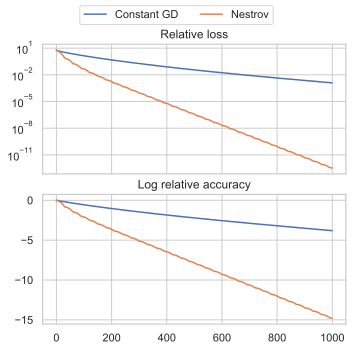

In [17]:
p3_test_setups = [
    ("Constant GD", partial(fixed_stepsize_step, stepsize=jconst(1 / lipschitz_p3_p1))),
    ("Nestrov", partial(nestrov_step, stepsize=jconst(1 / lipschitz_p3_p1))),
]

run_plot(p3_test_setups, qd_p3_p1, first_order_solve(qd_p3_p1))

Now we test the convergence of the constant step-size GD and Nesterov with different estimates of the Lipschitz constant. We use the $\ell_2$ norm of the primal distance to the optimal solution as the criterion for convergence; we consider an algorithm to have converged when the primal distance improves by a factor of $10$.

In [18]:
@typechecked
def convergence_test(
    step: StepFunction,
    qd: QuadraticOptimization,
    x_opt: Float[Array, " n"],
    /,
    max_iter: int = 1000,
) -> Bool[Scalar, ""]:
    xs, fs = descent(jnp.zeros(n), qd, step, max_iter=max_iter)
    return jnp.linalg.norm(xs[-1] - x_opt) / jnp.linalg.norm(jnp.zeros(n) - x_opt) < 0.1

In [19]:
step_size_indices = (jnp.arange(22) + 1) / 10
step_sizes_p3_p1 = step_size_indices / lipschitz_p3_p1


def experiment_p3(test_setups, learning_rate, func):
    results = {}
    for name, step in test_setups:
        step = partial(step, stepsize=jconst(learning_rate))
        results[name] = convergence_test(step, func, first_order_solve(func))
    return results


results = jax.vmap(partial(experiment_p3, p3_test_setups, func=qd_p3_p1), (0))(
    step_sizes_p3_p1
)

In [20]:
for step_size_index, result in zip(step_size_indices, tree_unstack(results)):
    print(f"Step size: {step_size_index:.1f} / L, convergence: ", end="")
    for name, res in result.items():
        print(f"{name}: {'✅' if res else '🚫'}", end="; ")
    print()

Step size: 0.1 / L, convergence: Constant GD: 🚫; Nestrov: 🚫; 
Step size: 0.2 / L, convergence: Constant GD: 🚫; Nestrov: ✅; 
Step size: 0.3 / L, convergence: Constant GD: 🚫; Nestrov: ✅; 
Step size: 0.4 / L, convergence: Constant GD: 🚫; Nestrov: ✅; 
Step size: 0.5 / L, convergence: Constant GD: 🚫; Nestrov: ✅; 
Step size: 0.6 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.7 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.8 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.9 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.0 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.1 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.2 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.3 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.4 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.5 / L, convergence: Constant GD: ✅; Nestrov: 🚫; 
Step size: 1.6 / L, convergence: Constant GD: ✅; Nestrov: 🚫; 
Step siz

From the previous output, we can see that Nestrov converges when the step size is not too large, and could still perform well when the step size is underestimated (i.e. the Lipschitz constant is overestimated). However, the constant step-size GD is sensitive to the step size, and it becomes very slow when the step size is small.

We will then repeat the process for P2 where the condition number is smaller.

L = 939.04
Running Constant GD step
Running Nestrov step


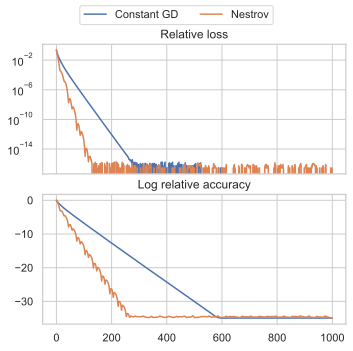

In [21]:
qd_p3_p2 = generate_qd(n, 0.01, 5.0, qd_p3_p2_key)
lipschitz_p3_p2 = jnp.max(jnp.linalg.eigvalsh(qd_p3_p2.Q))
print(f"L = {lipschitz_p3_p2:.2f}")

p3_test_setups = [
    ("Constant GD", partial(fixed_stepsize_step, stepsize=jconst(1 / lipschitz_p3_p2))),
    ("Nestrov", partial(nestrov_step, stepsize=jconst(1 / lipschitz_p3_p2))),
]

run_plot(p3_test_setups, qd_p3_p2, first_order_solve(qd_p3_p2), max_iter=1000)

We can observe that both algorithm converge relatively fast to the optimum with machine precision.

In [22]:
step_sizes_p3_p2 = step_size_indices / lipschitz_p3_p2
results = jax.vmap(partial(experiment_p3, p3_test_setups, func=qd_p3_p2), (0))(
    step_sizes_p3_p2
)
for step_size_index, result in zip(step_size_indices, tree_unstack(results)):
    print(f"Step size: {step_size_index:.1f} / L, convergence: ", end="")
    for name, res in result.items():
        print(f"{name}: {'✅' if res else '🚫'}", end="; ")
    print()

Step size: 0.1 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.2 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.3 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.4 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.5 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.6 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.7 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.8 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 0.9 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.0 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.1 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.2 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.3 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.4 / L, convergence: Constant GD: ✅; Nestrov: ✅; 
Step size: 1.5 / L, convergence: Constant GD: ✅; Nestrov: 🚫; 
Step size: 1.6 / L, convergence: Constant GD: ✅; Nestrov: 🚫; 
Step siz

This shows that constant-rate GD is less sensitive to the step size than Nesterov.

## Problem 4: Effect of noises in gradient estimation

In [23]:
p4_key = jr.key(my_hash("problem 4"))
qd_p4 = generate_qd(n, 1.0, 0.0, p4_key)
lipschitz_p4 = jnp.max(jnp.linalg.eigvalsh(qd_p4.Q))
x_opt_p4 = first_order_solve(qd_p4)

In [24]:
@typechecked
def noisy_step_adaptor(
    step: StepFunction,
    init_key: Key[Scalar, ""] = jr.key(1),
    noise_stddev: FloatLike = jconst(0.1),
) -> StepFunction:
    def noisy_step(
        x: Float[Array, " n"],
        fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
        extra: tuple[Any, Key[Scalar, ""]] | None = None,
    ) -> tuple[Float[Array, " n"], tuple[Any, Key[Scalar, ""]]]:
        orig_extra, key = extra if extra is not None else (None, init_key)
        key_consumed, new_key = jr.split(key, 2)
        normal_noise = jr.normal(key_consumed, x.shape) * noise_stddev

        def noisy_fun(x):
            return fun(x) + jnp.dot(normal_noise, x)

        new = step(x, noisy_fun, orig_extra)
        if isinstance(new, tuple):
            new_x, new_extra = new
        else:
            new_x, new_extra = new, None
        return new_x, (new_extra, new_key)

    return noisy_step

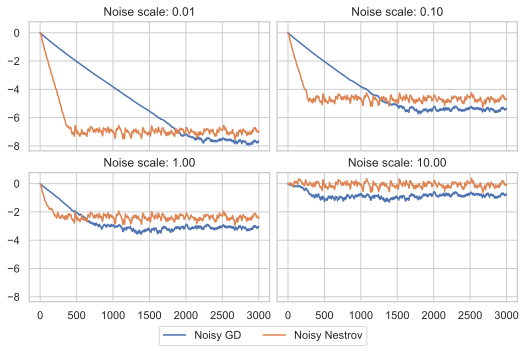

In [25]:
noisy_test_setup = [
    ("Noisy GD", partial(fixed_stepsize_step, stepsize=jconst(1 / lipschitz_p4))),
    ("Noisy Nestrov", partial(nestrov_step, stepsize=jconst(1 / lipschitz_p4))),
]

noise_scales = jnp.array([0.01, 0.1, 1.0, 10.0])

plt.ioff()
fig, axs = plt.subplots(
    2, 2, figsize=(7.2, 4.8), sharex=True, sharey=True, layout="constrained"
)
axs = cast(list[Axes], list(axs.flatten()))
for noise_scale, ax in zip(noise_scales, axs):
    ax.set_title(f"Noise scale: {noise_scale:.2f}")
    for name, step in noisy_test_setup:
        noisy_step = noisy_step_adaptor(step, noise_stddev=jconst(noise_scale))
        xs, fs = descent(jnp.zeros(n), qd_p4, noisy_step, max_iter=3000)
        ax.plot(
            jax.vmap(log_relative_accuracy, (0, None, None))(
                xs, x_opt_p4, jnp.zeros(n)
            ),
            label=name,
        )
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside lower center", ncol=2)
plt.show()

We can observe that Nesterov is more sensitive to the noise in the gradient estimation than the constant-rate GD, especially when the noise is large. When the noise is smaller, Nesterov initially converges faster, but to a bigger stochastic ball around the optimum.

## Problem 5: Restart of Nesterov

In [26]:
p5_key = jr.key(my_hash("problem 5"))
qd_p5 = generate_qd(n, 0.01, 5.0, p5_key)
lipschitz_p5 = jnp.max(jnp.linalg.eigvalsh(qd_p5.Q))
κ_p5 = condition_number(qd_p5.Q)
x_opt_p5 = first_order_solve(qd_p5)

Running Nesterov (no restart) step
Running Const-rate GD step
Running Nesterov (restart 1 √κ) step
Running Nesterov (restart 5 √κ) step
Running Nesterov (restart 20 √κ) step


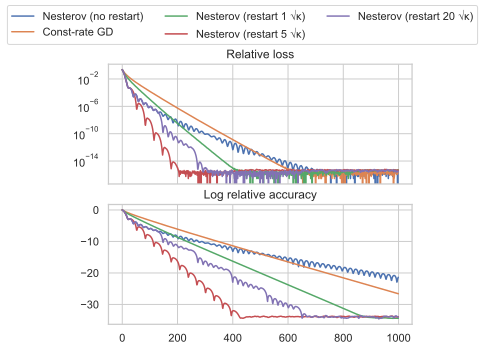

In [27]:
p5_test_setups = [
    (
        "Nesterov (no restart)",
        partial(
            nestrov_step,
            stepsize=jconst(1 / lipschitz_p5),
            restart=jnp.array(99999, dtype=int),
        ),
    ),
    ("Const-rate GD", partial(fixed_stepsize_step, stepsize=jconst(1 / lipschitz_p5))),
] + [
    (
        f"Nesterov (restart {k} √κ)",
        partial(
            nestrov_step,
            stepsize=jconst(1 / lipschitz_p5),
            restart=(k * jnp.sqrt(κ_p5)).astype(int),
        ),
    )
    for k in [1, 5, 20]
]
run_plot(p5_test_setups, qd_p5, x_opt_p5, max_iter=1000)

We can see that all of the algorithms converge. Among these algorithms, the best performing one is Nesterov with restarts every $5\sqrt\kappa$ iterations. Restarting more often (green) and less often (purple) both lead to slower convergence. This shows that the restart strategy needs a delicate selection of the restart frequency based on the features of the problem.